### Modeling with Keras

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


#helper function to plot performance
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [11]:
df = pd.read_csv('data_clean.csv')
df.head()

,headline,is_sarcastic,word_count
0,former versace store clerk sues over secret bl...,0,12
1,the roseanne revival catches up to our thorny ...,0,14
2,mom starting to fear sons web series closest t...,1,14
3,boehner just wants wife to listen not come up ...,1,13
4,jk rowling wishes snape happy birthday in the ...,0,11


In [12]:
VOCAB_MAX = 10000 #max words to be used (most frequenct)
SEQUENCE_LENGTH_LIMIT = 100
EMBEDDING_DIM = 20 #Max headline number of words is 20

#text preprocessing for tf
tokenizer = Tokenizer(num_words = VOCAB_MAX)
tokenizer.fit_on_texts(df.headline.values)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')

X = tokenizer.texts_to_sequences(df.headline.values)
X = pad_sequences(X, maxlen=SEQUENCE_LENGTH_LIMIT)

print("Shape of data tensor:", X.shape)

Y = df.is_sarcastic.values
print(Y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,Y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

Found 28862 unique tokens
Shape of data tensor: (28515, 100)
(28515,)
(22812, 100) (22812,)
(5703, 100) (5703,)


In [34]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### LSTM Model Keras

In [13]:
## Keras Sequential model
model = keras.Sequential()
model.add(layers.Embedding(VOCAB_MAX, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 20)           200000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               43520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 247,681
Trainable params: 247,681
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30


2022-03-16 13:14:17.467640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 13:14:17.597559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 13:14:17.606490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 13:14:17.983433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 13:14:17.996742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.5648

2022-03-16 13:14:24.407826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 13:14:24.450854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 13:14:24.457230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 9s 170ms/step - loss: 0.6834 - accuracy: 0.5648 - val_loss: 0.6407 - val_accuracy: 0.6893
Epoch 2/30
40/40 [==============================] - 5s 126ms/step - loss: 0.5358 - accuracy: 0.7604 - val_loss: 0.4794 - val_accuracy: 0.7520
Epoch 3/30
40/40 [==============================] - 5s 129ms/step - loss: 0.4716 - accuracy: 0.7724 - val_loss: 0.5526 - val_accuracy: 0.7020
Epoch 4/30
40/40 [==============================] - 5s 128ms/step - loss: 0.5376 - accuracy: 0.7289 - val_loss: 0.5359 - val_accuracy: 0.7169
Epoch 5/30
40/40 [==============================] - 5s 128ms/step - loss: 0.5010 - accuracy: 0.7555 - val_loss: 0.4897 - val_accuracy: 0.7638
Epoch 6/30
40/40 [==============================] - 5s 126ms/step - loss: 0.4055 - accuracy: 0.8181 - val_loss: 0.3720 - val_accuracy: 0.8326
Epoch 7/30
40/40 [==============================] - 5s 126ms/step - loss: 0.3249 - accuracy: 0.8680 - val_loss: 0.4127 - val_accuracy: 0.8142
Epoch 8/30
40/40 

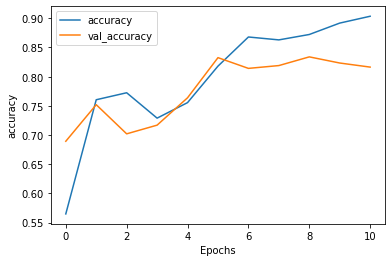

In [14]:
history = model.fit(X_train, y_train,
                   epochs = 30,
                   batch_size=514,
                   validation_split=0.1,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
                   verbose = 1)

plot_graphs(history, "accuracy")

In [20]:
#model.save('models/LSTM_classifier_V1.h5')
#model.save('models/LSTM_classifier_V1', save_format="tf")

In [22]:
y_pred =model.predict(X_test)

In [27]:
import numpy as np

#round the predictions to 0 or 1
y_pred = np.rint(y_pred)

In [31]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(y_test, y_pred)

In [32]:
def plot_confusion_matrix(cm, classes, 
                         normalize = False,
                         title="Confusion Matrix",
                         cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm= cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without normalization")
        
    print(cm)
    
    thresh = cm.max() / 2. 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel("True Label")
        plt.xlabel("Predicted label")

Confusion Matrix, without normalization
[[2563  483]
 [ 554 2103]]


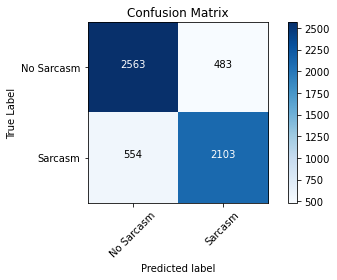

In [33]:
cm_plot_labels = ['No Sarcasm', "Sarcasm"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")